# TRAINING RESNET50 FOR MULTI-LABEL CLASSIFICATION


#### Connecting to drive

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Adding your absolute path of your project folder to system path
import sys
sys.path.append("/content/drive/My Drive/CS 553/Project/Data/Multi_Label_dataset")

In [ ]:
%cd "/content/drive/My Drive/CS 553/Project/Data/Multi_Label_dataset"

/content/drive/My Drive/CS 553/Project/Data/Multi_Label_dataset


In [ ]:
# Checking status of gpu available through google collab
!nvidia-smi

Mon Nov 18 18:11:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

!pip install --upgrade --force-reinstall torch torchvision torchaudio
!pip install numpy --upgrade --force-reinstall

#### Loading Data and Spliting in Train,Validation and Test

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        #Image id from csv file
        self.all_image_names = self.csv[:]['Id']
        #labels from train csv file
        self.all_labels = np.array(self.csv.drop(['Id', 'Genre'], axis=1))
        #Train-Validation data split (85% train and 15% validation)
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        #set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms - data augmentation
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
                transforms.Normalize(            # Normalize the tensor
                          mean=[0.5, 0.5, 0.5],  # Using ImageNet mean and std
                          std=[0.5, 0.5, 0.5]
                          )
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        # set the test data images and label (last 10 images)
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = cv2.imread(f"Images/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            'image':image.clone().detach() if isinstance(image, torch.Tensor) else torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

#### Evaluation Metrics

In [ ]:
from sklearn.metrics import average_precision_score,roc_auc_score
def compute_mAP(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)

def comput_roc(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    ROC = []
    for i in range(y_true.shape[0]):
        ROC.append(roc_auc_score(y_true[i],y_pred[i]))
    return np.mean(ROC)

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro',zero_division=0),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro',zero_division=0),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples',zero_division=0)
            }

#### Creating Train Function

In [ ]:
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        #setting gradients to zero
        optimizer.zero_grad()
        #forward pass
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        train_running_mAP += compute_mAP(outputs,target)
        train_running_ROC += comput_roc(outputs,target)
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

    train_loss = train_running_loss / counter
    train_mAP = train_running_mAP/counter
    train_ROC = train_running_ROC/counter
    print(f"Train mAP: {train_mAP:.4f}")
    print(f'Train ROC: {train_ROC:.4f}')
    return train_loss,train_mAP,train_ROC


#### Creating Validation Function

In [ ]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_mAP = 0.0
    val_running_ROC = 0.0
    with torch.no_grad():
        model_result = []
        targets = []
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            model_result.extend(outputs.cpu().numpy())
            targets.extend(target.cpu().numpy())
            val_running_mAP += compute_mAP(outputs,target)
            val_running_ROC += comput_roc(outputs,target)
            val_running_loss += loss.item()
        result = calculate_metrics(np.array(model_result), np.array(targets))
        val_loss = val_running_loss / counter
        val_mAP = val_running_mAP/counter
        val_ROC = val_running_ROC/counter
        print("epoch:{:2d}  test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))
        print(f"Val mAP: {val_mAP:.4f}")
        print(f'Val ROC: {val_ROC:.4f}')
        return val_loss,val_mAP,val_ROC

#ResNet MODEL

In [ ]:
from torchvision import models as models
import torch.nn as nn
def create_model(pretrained, requires_grad):
    model = models.resnet50(progress=True)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

#TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#intialize the model
# Create a ResNet50 model with frozen layers
model = create_model(pretrained=True, requires_grad=False).to(device)

In [ ]:
############ Traning for 4 epochs ############
#parameters
lr = 0.001
epochs = 4
batch_size = 256
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# read the training csv file
train_csv = pd.read_csv('train.csv')

# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False
)



Number of training images: 6165
Number of validation images: 1089


In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
from torchinfo import summary


# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape
ResNet (ResNet)                          [256, 3, 400, 400]
├─Conv2d (conv1)                         [256, 3, 400, 400]
├─BatchNorm2d (bn1)                      [256, 64, 200, 200]
├─ReLU (relu)                            [256, 64, 200, 200]
├─MaxPool2d (maxpool)                    [256, 64, 200, 200]
├─Sequential (layer1)                    [256, 64, 100, 100]
│    └─Bottleneck (0)                    [256, 64, 100, 100]
│    │    └─Conv2d (conv1)               [256, 64, 100, 100]
│    │    └─BatchNorm2d (bn1)            [256, 64, 100, 100]
│    │    └─ReLU (relu)                  [256, 64, 100, 100]
│    │    └─Conv2d (conv2)               [256, 64, 100, 100]
│    │    └─BatchNorm2d (bn2)            [256, 64, 100, 100]
│    │    └─ReLU (relu)                  [256, 64, 100, 100]
│    │    └─Conv2d (conv3)               [256, 64, 100, 100]
│    │    └─BatchNorm2d (bn3)            [256, 256, 100, 100]
│    │    └─Sequential (downsampl

##### Training Run 1 - 4 epochs

In [ ]:
train_loss = []
valid_loss = []
train_mAP = []
train_ROC = []
valid_mAP = []
valid_ROC = []
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 4
Training


25it [09:15, 22.22s/it]


Train mAP: 0.5392
Train ROC: 0.8221
Validating


5it [06:41, 80.33s/it]


epoch: 0  test: micro f1: 0.193 macro f1: 0.021 samples f1: 0.173
Val mAP: 0.4494
Val ROC: 0.7664
Train Loss: 0.2556
Val Loss: 0.2618
Epoch 2 of 4
Training


25it [02:45,  6.60s/it]


Train mAP: 0.5604
Train ROC: 0.8342
Validating


5it [00:14,  2.98s/it]


epoch: 1  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4916
Val ROC: 0.7773
Train Loss: 0.2427
Val Loss: 0.2561
Epoch 3 of 4
Training


25it [02:44,  6.56s/it]


Train mAP: 0.5586
Train ROC: 0.8331
Validating


5it [00:14,  2.98s/it]


epoch: 2  test: micro f1: 0.269 macro f1: 0.024 samples f1: 0.270
Val mAP: 0.4826
Val ROC: 0.7583
Train Loss: 0.2433
Val Loss: 0.2607
Epoch 4 of 4
Training


25it [02:47,  6.68s/it]


Train mAP: 0.5612
Train ROC: 0.8327
Validating


5it [00:15,  3.02s/it]

epoch: 3  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4719
Val ROC: 0.7590
Train Loss: 0.2425
Val Loss: 0.2592


In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 4
Training


25it [02:49,  6.79s/it]


Train mAP: 0.5665
Train ROC: 0.8367
Validating


5it [00:15,  3.04s/it]


epoch: 0  test: micro f1: 0.066 macro f1: 0.012 samples f1: 0.052
Val mAP: 0.4928
Val ROC: 0.7785
Train Loss: 0.2392
Val Loss: 0.2545
Epoch 2 of 4
Training


25it [02:51,  6.85s/it]


Train mAP: 0.5713
Train ROC: 0.8401
Validating


5it [00:15,  3.10s/it]


epoch: 1  test: micro f1: 0.286 macro f1: 0.027 samples f1: 0.291
Val mAP: 0.4860
Val ROC: 0.7549
Train Loss: 0.2402
Val Loss: 0.2688
Epoch 3 of 4
Training


25it [02:46,  6.64s/it]


Train mAP: 0.5716
Train ROC: 0.8352
Validating


5it [00:15,  3.04s/it]


epoch: 2  test: micro f1: 0.283 macro f1: 0.025 samples f1: 0.289
Val mAP: 0.4938
Val ROC: 0.7993
Train Loss: 0.2404
Val Loss: 0.2574
Epoch 4 of 4
Training


25it [02:48,  6.76s/it]


Train mAP: 0.5657
Train ROC: 0.8369
Validating


5it [00:15,  3.02s/it]

epoch: 3  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.289
Val mAP: 0.4918
Val ROC: 0.7841
Train Loss: 0.2424
Val Loss: 0.2581


In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+8} of {epochs+8}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 9 of 12
Training


25it [02:46,  6.65s/it]


Train mAP: 0.5732
Train ROC: 0.8412
Validating


5it [00:15,  3.07s/it]


epoch: 0  test: micro f1: 0.294 macro f1: 0.031 samples f1: 0.298
Val mAP: 0.4935
Val ROC: 0.7727
Train Loss: 0.2388
Val Loss: 0.2599
Epoch 10 of 12
Training


25it [02:44,  6.59s/it]


Train mAP: 0.5705
Train ROC: 0.8400
Validating


5it [00:15,  3.01s/it]


epoch: 1  test: micro f1: 0.290 macro f1: 0.029 samples f1: 0.294
Val mAP: 0.4904
Val ROC: 0.7852
Train Loss: 0.2401
Val Loss: 0.2572
Epoch 11 of 12
Training


25it [02:45,  6.61s/it]


Train mAP: 0.5684
Train ROC: 0.8391
Validating


5it [00:15,  3.04s/it]


epoch: 2  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4751
Val ROC: 0.7758
Train Loss: 0.2407
Val Loss: 0.2610
Epoch 12 of 12
Training


25it [02:51,  6.85s/it]


Train mAP: 0.5717
Train ROC: 0.8408
Validating


5it [00:15,  3.04s/it]

epoch: 3  test: micro f1: 0.281 macro f1: 0.025 samples f1: 0.287
Val mAP: 0.4973
Val ROC: 0.7937
Train Loss: 0.2393
Val Loss: 0.2523


In [ ]:
torch.save(model,"Model_2.pt")

In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+12} of {epochs+12}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 13 of 16
Training


25it [02:49,  6.76s/it]


Train mAP: 0.5795
Train ROC: 0.8449
Validating


5it [00:15,  3.08s/it]


epoch: 0  test: micro f1: 0.267 macro f1: 0.026 samples f1: 0.268
Val mAP: 0.4858
Val ROC: 0.7722
Train Loss: 0.2365
Val Loss: 0.2558
Epoch 14 of 16
Training


25it [02:53,  6.95s/it]


Train mAP: 0.5697
Train ROC: 0.8406
Validating


5it [00:18,  3.77s/it]


epoch: 1  test: micro f1: 0.275 macro f1: 0.025 samples f1: 0.277
Val mAP: 0.4753
Val ROC: 0.7753
Train Loss: 0.2401
Val Loss: 0.2566
Epoch 15 of 16
Training


25it [02:49,  6.78s/it]


Train mAP: 0.5731
Train ROC: 0.8413
Validating


5it [00:15,  3.04s/it]


epoch: 2  test: micro f1: 0.086 macro f1: 0.014 samples f1: 0.068
Val mAP: 0.4903
Val ROC: 0.7716
Train Loss: 0.2388
Val Loss: 0.2555
Epoch 16 of 16
Training


25it [02:51,  6.86s/it]


Train mAP: 0.5658
Train ROC: 0.8397
Validating


5it [00:15,  3.05s/it]

epoch: 3  test: micro f1: 0.288 macro f1: 0.028 samples f1: 0.294
Val mAP: 0.4882
Val ROC: 0.7837
Train Loss: 0.2399
Val Loss: 0.2572


In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+16} of {epochs+16}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 17 of 26
Training


25it [02:51,  6.85s/it]


Train mAP: 0.5709
Train ROC: 0.8388
Validating


5it [00:14,  2.97s/it]


epoch: 0  test: micro f1: 0.288 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4832
Val ROC: 0.7643
Train Loss: 0.2407
Val Loss: 0.2641
Epoch 18 of 26
Training


25it [02:47,  6.72s/it]


Train mAP: 0.5709
Train ROC: 0.8405
Validating


5it [00:15,  3.06s/it]


epoch: 1  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.289
Val mAP: 0.4986
Val ROC: 0.7924
Train Loss: 0.2394
Val Loss: 0.2592
Epoch 19 of 26
Training


25it [02:42,  6.52s/it]


Train mAP: 0.5750
Train ROC: 0.8418
Validating


5it [00:14,  2.96s/it]


epoch: 2  test: micro f1: 0.289 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4904
Val ROC: 0.7778
Train Loss: 0.2384
Val Loss: 0.2575
Epoch 20 of 26
Training


25it [02:47,  6.71s/it]


Train mAP: 0.5751
Train ROC: 0.8422
Validating


5it [00:14,  2.97s/it]


epoch: 3  test: micro f1: 0.291 macro f1: 0.029 samples f1: 0.295
Val mAP: 0.4820
Val ROC: 0.7766
Train Loss: 0.2383
Val Loss: 0.2631
Epoch 21 of 26
Training


25it [02:44,  6.58s/it]


Train mAP: 0.5736
Train ROC: 0.8417
Validating


5it [00:14,  2.94s/it]


epoch: 4  test: micro f1: 0.291 macro f1: 0.029 samples f1: 0.295
Val mAP: 0.4845
Val ROC: 0.7786
Train Loss: 0.2381
Val Loss: 0.2630
Epoch 22 of 26
Training


25it [02:46,  6.67s/it]


Train mAP: 0.5736
Train ROC: 0.8430
Validating


5it [00:14,  2.96s/it]


epoch: 5  test: micro f1: 0.284 macro f1: 0.026 samples f1: 0.290
Val mAP: 0.4832
Val ROC: 0.7823
Train Loss: 0.2384
Val Loss: 0.2576
Epoch 23 of 26
Training


25it [02:47,  6.69s/it]


Train mAP: 0.5731
Train ROC: 0.8415
Validating


5it [00:14,  2.95s/it]


epoch: 6  test: micro f1: 0.292 macro f1: 0.034 samples f1: 0.293
Val mAP: 0.4958
Val ROC: 0.7969
Train Loss: 0.2374
Val Loss: 0.2482
Epoch 24 of 26
Training


25it [02:42,  6.49s/it]


Train mAP: 0.5686
Train ROC: 0.8381
Validating


5it [00:15,  3.01s/it]


epoch: 7  test: micro f1: 0.302 macro f1: 0.034 samples f1: 0.305
Val mAP: 0.4896
Val ROC: 0.7676
Train Loss: 0.2416
Val Loss: 0.2622
Epoch 25 of 26
Training


25it [02:47,  6.70s/it]


Train mAP: 0.5769
Train ROC: 0.8418
Validating


5it [00:14,  2.98s/it]


epoch: 8  test: micro f1: 0.287 macro f1: 0.034 samples f1: 0.289
Val mAP: 0.5017
Val ROC: 0.7875
Train Loss: 0.2379
Val Loss: 0.2520
Epoch 26 of 26
Training


25it [02:47,  6.69s/it]


Train mAP: 0.5780
Train ROC: 0.8431
Validating


5it [00:14,  2.99s/it]

epoch: 9  test: micro f1: 0.302 macro f1: 0.034 samples f1: 0.305
Val mAP: 0.4882
Val ROC: 0.7661
Train Loss: 0.2372
Val Loss: 0.2605


In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+26} of {epochs+26}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 27 of 36
Training


25it [02:51,  6.85s/it]


Train mAP: 0.5760
Train ROC: 0.8411
Validating


5it [00:14,  2.99s/it]


epoch: 0  test: micro f1: 0.289 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4835
Val ROC: 0.7618
Train Loss: 0.2387
Val Loss: 0.2663
Epoch 28 of 36
Training


25it [02:51,  6.84s/it]


Train mAP: 0.5743
Train ROC: 0.8422
Validating


5it [00:15,  3.06s/it]


epoch: 1  test: micro f1: 0.287 macro f1: 0.027 samples f1: 0.292
Val mAP: 0.4832
Val ROC: 0.7651
Train Loss: 0.2388
Val Loss: 0.2640
Epoch 29 of 36
Training


25it [02:51,  6.87s/it]


Train mAP: 0.5739
Train ROC: 0.8425
Validating


5it [00:15,  3.05s/it]


epoch: 2  test: micro f1: 0.289 macro f1: 0.031 samples f1: 0.293
Val mAP: 0.4779
Val ROC: 0.7838
Train Loss: 0.2383
Val Loss: 0.2563
Epoch 30 of 36
Training


25it [02:45,  6.60s/it]


Train mAP: 0.5768
Train ROC: 0.8445
Validating


5it [00:15,  3.04s/it]


epoch: 3  test: micro f1: 0.288 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4913
Val ROC: 0.7705
Train Loss: 0.2367
Val Loss: 0.2610
Epoch 31 of 36
Training


25it [02:44,  6.57s/it]


Train mAP: 0.5781
Train ROC: 0.8427
Validating


5it [00:14,  2.99s/it]


epoch: 4  test: micro f1: 0.287 macro f1: 0.028 samples f1: 0.292
Val mAP: 0.4812
Val ROC: 0.7767
Train Loss: 0.2377
Val Loss: 0.2664
Epoch 32 of 36
Training


25it [02:45,  6.61s/it]


Train mAP: 0.5747
Train ROC: 0.8424
Validating


5it [00:15,  3.02s/it]


epoch: 5  test: micro f1: 0.285 macro f1: 0.027 samples f1: 0.291
Val mAP: 0.4978
Val ROC: 0.7937
Train Loss: 0.2394
Val Loss: 0.2552
Epoch 33 of 36
Training


25it [02:44,  6.58s/it]


Train mAP: 0.5819
Train ROC: 0.8437
Validating


5it [00:15,  3.03s/it]


epoch: 6  test: micro f1: 0.306 macro f1: 0.035 samples f1: 0.308
Val mAP: 0.4827
Val ROC: 0.7758
Train Loss: 0.2358
Val Loss: 0.2619
Epoch 34 of 36
Training


25it [02:44,  6.59s/it]


Train mAP: 0.5865
Train ROC: 0.8503
Validating


5it [00:15,  3.02s/it]


epoch: 7  test: micro f1: 0.300 macro f1: 0.033 samples f1: 0.303
Val mAP: 0.4888
Val ROC: 0.7768
Train Loss: 0.2329
Val Loss: 0.2576
Epoch 35 of 36
Training


25it [02:43,  6.55s/it]


Train mAP: 0.5804
Train ROC: 0.8441
Validating


5it [00:15,  3.01s/it]


epoch: 8  test: micro f1: 0.288 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4820
Val ROC: 0.7876
Train Loss: 0.2361
Val Loss: 0.2572
Epoch 36 of 36
Training


25it [02:43,  6.55s/it]


Train mAP: 0.5797
Train ROC: 0.8445
Validating


5it [00:15,  3.05s/it]

epoch: 9  test: micro f1: 0.301 macro f1: 0.033 samples f1: 0.303
Val mAP: 0.5010
Val ROC: 0.7800
Train Loss: 0.2360
Val Loss: 0.2584


In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+36} of {epochs+36}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 37 of 46
Training


25it [02:45,  6.63s/it]


Train mAP: 0.5767
Train ROC: 0.8436
Validating


5it [00:15,  3.04s/it]


epoch: 0  test: micro f1: 0.287 macro f1: 0.028 samples f1: 0.292
Val mAP: 0.4922
Val ROC: 0.7899
Train Loss: 0.2363
Val Loss: 0.2550
Epoch 38 of 46
Training


25it [02:43,  6.55s/it]


Train mAP: 0.5812
Train ROC: 0.8468
Validating


5it [00:15,  3.02s/it]


epoch: 1  test: micro f1: 0.272 macro f1: 0.025 samples f1: 0.273
Val mAP: 0.4992
Val ROC: 0.7933
Train Loss: 0.2356
Val Loss: 0.2517
Epoch 39 of 46
Training


25it [02:43,  6.56s/it]


Train mAP: 0.5704
Train ROC: 0.8393
Validating


5it [00:15,  3.14s/it]


epoch: 2  test: micro f1: 0.288 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4819
Val ROC: 0.7712
Train Loss: 0.2403
Val Loss: 0.2598
Epoch 40 of 46
Training


25it [02:42,  6.51s/it]


Train mAP: 0.5740
Train ROC: 0.8423
Validating


5it [00:14,  2.97s/it]


epoch: 3  test: micro f1: 0.282 macro f1: 0.028 samples f1: 0.287
Val mAP: 0.4813
Val ROC: 0.7855
Train Loss: 0.2381
Val Loss: 0.2549
Epoch 41 of 46
Training


25it [02:43,  6.53s/it]


Train mAP: 0.5708
Train ROC: 0.8393
Validating


5it [00:14,  2.97s/it]


epoch: 4  test: micro f1: 0.231 macro f1: 0.027 samples f1: 0.214
Val mAP: 0.5009
Val ROC: 0.7780
Train Loss: 0.2396
Val Loss: 0.2528
Epoch 42 of 46
Training


25it [02:43,  6.53s/it]


Train mAP: 0.5692
Train ROC: 0.8407
Validating


5it [00:14,  2.94s/it]


epoch: 5  test: micro f1: 0.281 macro f1: 0.027 samples f1: 0.286
Val mAP: 0.4843
Val ROC: 0.7880
Train Loss: 0.2427
Val Loss: 0.2565
Epoch 43 of 46
Training


25it [02:41,  6.46s/it]


Train mAP: 0.5780
Train ROC: 0.8442
Validating


5it [00:14,  2.94s/it]


epoch: 6  test: micro f1: 0.291 macro f1: 0.031 samples f1: 0.294
Val mAP: 0.4883
Val ROC: 0.7741
Train Loss: 0.2374
Val Loss: 0.2560
Epoch 44 of 46
Training


25it [02:42,  6.49s/it]


Train mAP: 0.5774
Train ROC: 0.8427
Validating


5it [00:14,  2.96s/it]


epoch: 7  test: micro f1: 0.290 macro f1: 0.033 samples f1: 0.292
Val mAP: 0.4902
Val ROC: 0.7934
Train Loss: 0.2372
Val Loss: 0.2506
Epoch 45 of 46
Training


25it [02:47,  6.70s/it]


Train mAP: 0.5811
Train ROC: 0.8478
Validating


5it [00:14,  2.95s/it]


epoch: 8  test: micro f1: 0.298 macro f1: 0.034 samples f1: 0.300
Val mAP: 0.4855
Val ROC: 0.7642
Train Loss: 0.2354
Val Loss: 0.2578
Epoch 46 of 46
Training


25it [02:43,  6.54s/it]


Train mAP: 0.5791
Train ROC: 0.8443
Validating


5it [00:14,  2.98s/it]

epoch: 9  test: micro f1: 0.278 macro f1: 0.033 samples f1: 0.275
Val mAP: 0.4725
Val ROC: 0.7869
Train Loss: 0.2362
Val Loss: 0.2619


In [ ]:
epochs_comp = epochs*3+16
epochs_comp

46

In [ ]:
 # save the trained model to disk
 torch.save({
     'epoch': epochs_comp,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': criterion,
                 }, 'model2.pth')

# PLOTTONG GRAPHS

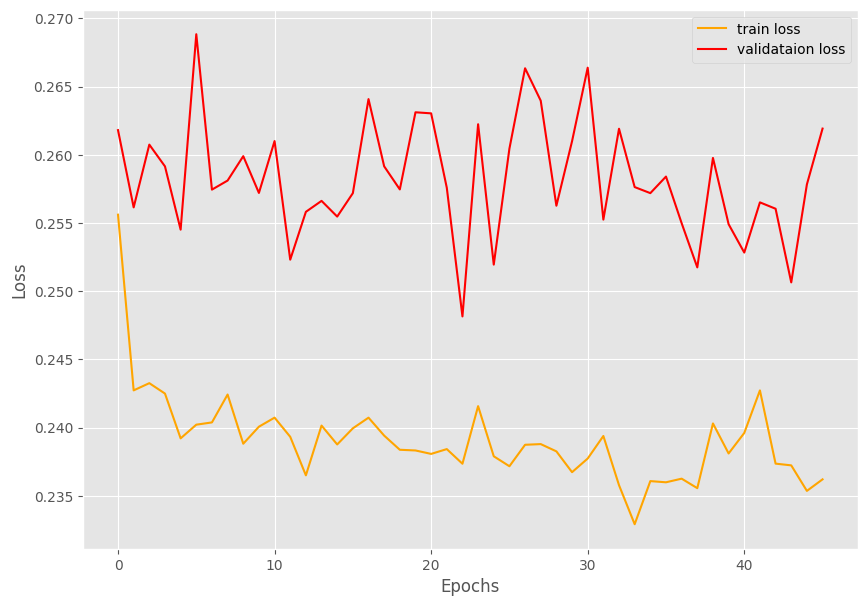

In [ ]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../loss.png')
plt.show()

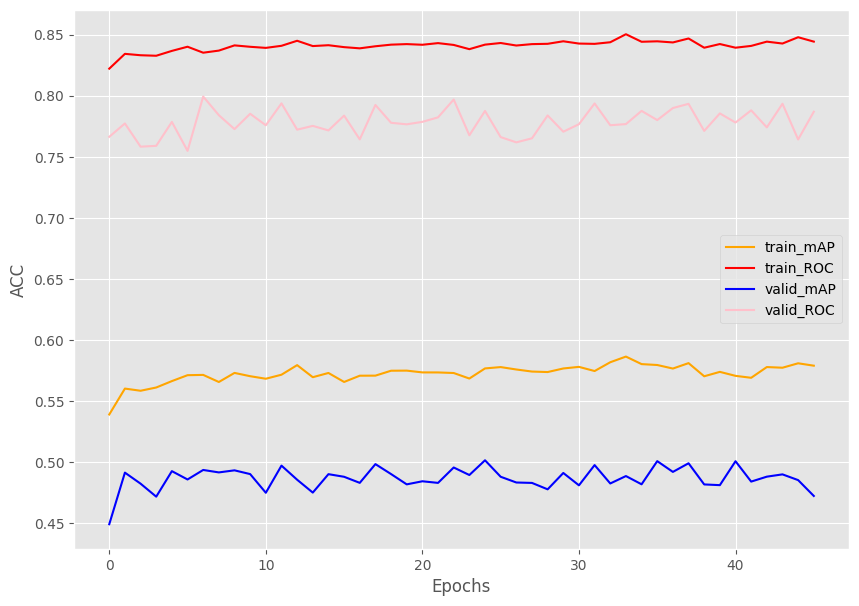

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_mAP, color='orange', label='train_mAP')
plt.plot(train_ROC, color='red', label='train_ROC')
plt.plot(valid_mAP, color='blue',label ='valid_mAP')
plt.plot(valid_ROC, color='pink', label='valid_ROC')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.savefig('../ACC.png')
plt.show()

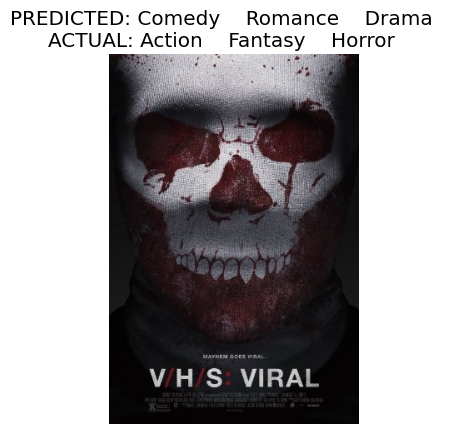

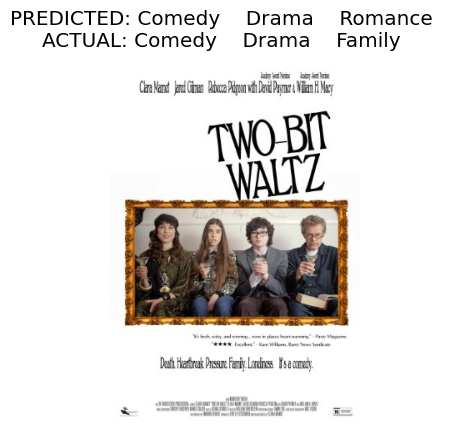

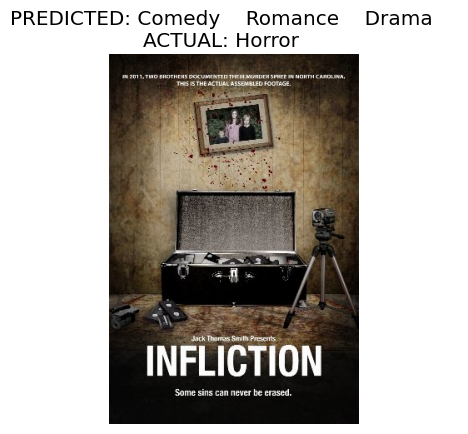

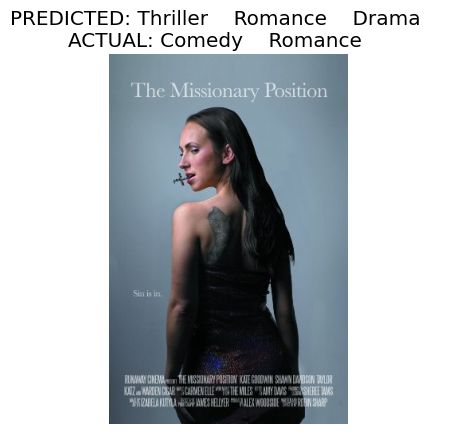

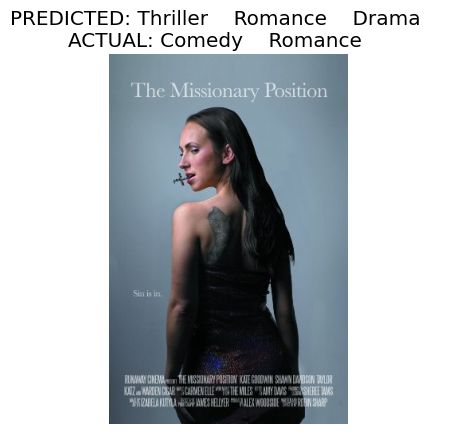

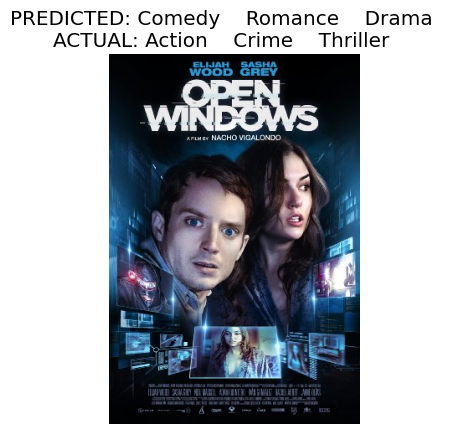

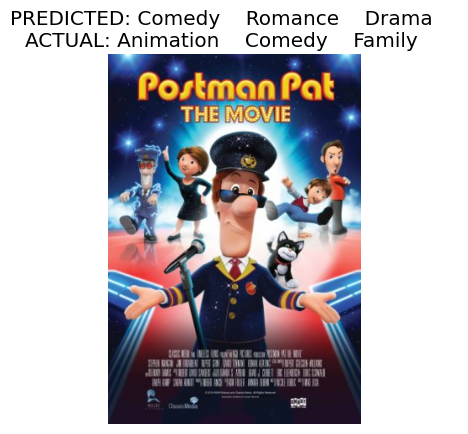

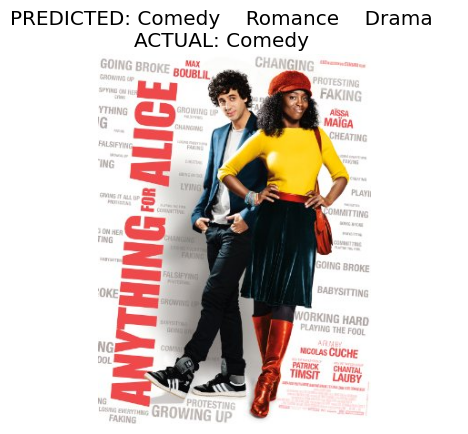

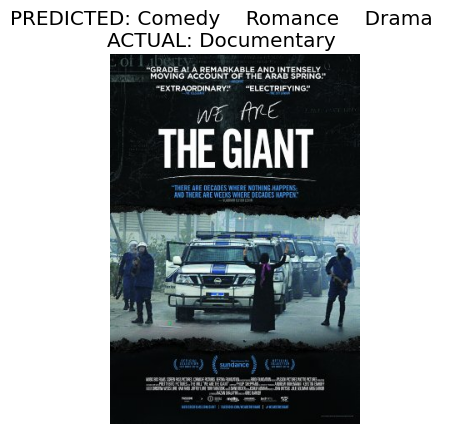

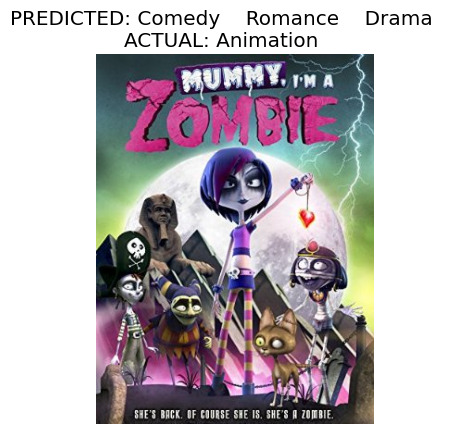

In [ ]:
train_csv = pd.read_csv('train.csv')
genres = train_csv.columns.values[2:]
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False
)
all_preds = []
all_labels = []
for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label'].to(device)
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-3:]
    ########## included later ###############
    all_preds.append(preds.cpu().numpy())
    all_labels.append(target.cpu().numpy())
    #########################################
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{genres[best[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{genres[target_indices[i]]}    "
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"inference_{counter}.jpg")
    plt.show()


